In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, subprocess, csv, re
from pathlib import Path

sys.path.append('D:/Dropbox/py_projects/customlib/')
import customlib as cl

import datetime

import numpy as np
import scipy.constants as pc
import pandas as pd

import scipy.signal as sps

import matplotlib.pyplot as plt
import matplotlib.cm as mcm

In [54]:
# read csv file into memory

dirname = 'D:/Dropbox/py_projects/covid-19/data/raw/'
filename = 'county_population_2020.csv'
# set data type. used for scans with current LakeShore 3-axis probe
kwargs = {'delimiter':',', 'header':0, 'names':['county', 'pop', 'growthrate']}

# pass kwargs to .read_csv()
dfpop = pd.read_csv(dirname+filename, **kwargs)
dfpop['county'] = dfpop['county'].str.slice(stop=-7)

In [72]:
# read csv file into memory

dirname = 'D:/Dropbox/py_projects/covid-19/data/raw/covid-19-data/'
filename = 'us-counties.csv'
# set data type. used for scans with current LakeShore 3-axis probe
kwargs = {'delimiter':',', 'header':0}

# pass kwargs to .read_csv()
dfc = pd.read_csv(dirname+filename, **kwargs)

# make a days column 
dfc['days'] = pd.to_numeric(pd.to_datetime(dfc['date'])).to_numpy() / (24*60*60*1e9)
# starting point 
t0 = dfc['days'].min()
dfc['days'] = dfc['days'] - t0

In [73]:
statelist = ['California', 'Georgia', 'New York']
countylistca = ['Los Angeles', 'Orange', 'Ventura']
countylistga = ['Fulton', 'DeKalb', 'Decatur', 'Cobb']


dfcla = dfc[(dfc['state']=='California') & dfc['county'].isin(countylistca)]
dfcla = dfcla.copy()

dfcatl = dfc[(dfc['state']=='Georgia') & dfc['county'].isin(countylistga)]
dfcatl = dfcatl.copy()

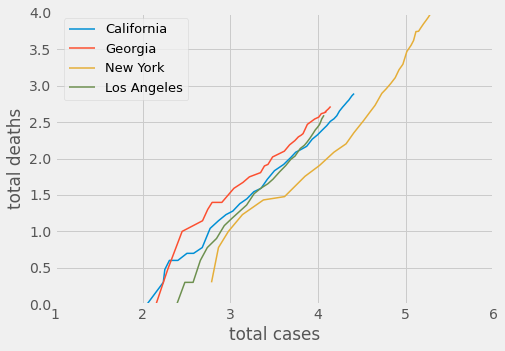

In [74]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(7,5))

for s in statelist:
    dfstemp = dfc[dfc['state'] == s ].groupby('date', sort=False).sum()
    xvec = np.log10(dfstemp.cases.to_numpy())
    yvec = np.log10(dfstemp.deaths.to_numpy())
    ls = dict(linewidth=1.50,linestyle='-',marker='o',ms=0,mfc='none',
          alpha=1)
    ax.plot(xvec,yvec,**ls)

xvec = np.log10(dfcla.groupby('date',sort=False).sum().cases.to_numpy())
yvec = np.log10(dfcla.groupby('date',sort=False).sum().deaths.to_numpy())
ax.plot(xvec,yvec,**ls)

plt.axis([1,6,0,4])
plt.xlabel('total cases')
plt.ylabel('total deaths')
plt.legend(statelist+['Los Angeles'],
           fontsize=13,loc=(0.02,0.7))

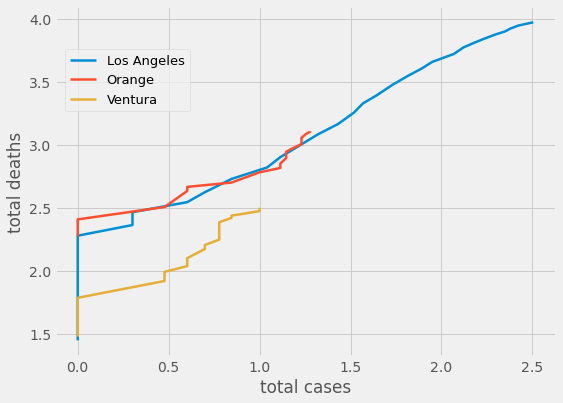

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
for c in countylistca:
    dftemp = dfcla[dfcla['county']==c]
    xvec = np.log10(dftemp['deaths'])
    yvec = np.log10(dftemp['cases'])
    ls = dict(linewidth=2.50,linestyle='-',marker='o',ms=0,mfc='none',
          alpha=1)
    ax.plot(xvec,yvec,**ls)
    
    
# plt.axis([1,6,0,4])
plt.xlabel('total cases')
plt.ylabel('total deaths')
plt.legend(countylistca,
           fontsize=13,loc=(0.02,0.7))

# new cases vs total cases

In [75]:
def df_addnew(dfcity,countylist):
    dfcity['cases_new'] = pd.Series(np.zeros(dfcity.shape[0]), index=dfcity.index)
    dfcity['deaths_new'] = pd.Series(np.zeros(dfcity.shape[0]), index=dfcity.index)
    for c in countylist:
        dftemp = dfcity[dfcity['county'] == c]
        ctemp = dftemp['cases'].to_numpy()
        dtemp = dftemp['deaths'].to_numpy()
        newc = np.zeros(ctemp.shape)
        newc[1:] = ctemp[1:]-ctemp[:-1]
        newd = np.zeros(dtemp.shape)
        newd[1:] = dtemp[1:] - dtemp[:-1]
        dfcity.loc[dftemp.index,['cases_new']] = newc
        dfcity.loc[dftemp.index, ['deaths_new']] = newd
    return dfcity

dfcla = df_addnew(dfcla, countylistca)
dfcatl = df_addnew(dfcatl, countylistga)

In [76]:

dfcla

,date,county,state,fips,cases,deaths,days,cases_new,deaths_new
5,2020-01-25,Orange,California,6059.0,1,0,4.0,0.0,0.0
9,2020-01-26,Los Angeles,California,6037.0,1,0,5.0,0.0,0.0
10,2020-01-26,Orange,California,6059.0,1,0,5.0,0.0,0.0
14,2020-01-27,Los Angeles,California,6037.0,1,0,6.0,0.0,0.0
15,2020-01-27,Orange,California,6059.0,1,0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
54040,2020-04-13,Orange,California,6059.0,1283,19,83.0,6.0,0.0
54064,2020-04-13,Ventura,California,6111.0,317,10,83.0,3.0,0.0
56724,2020-04-14,Los Angeles,California,6037.0,10047,360,84.0,627.0,40.0
56733,2020-04-14,Orange,California,6059.0,1299,19,84.0,16.0,0.0


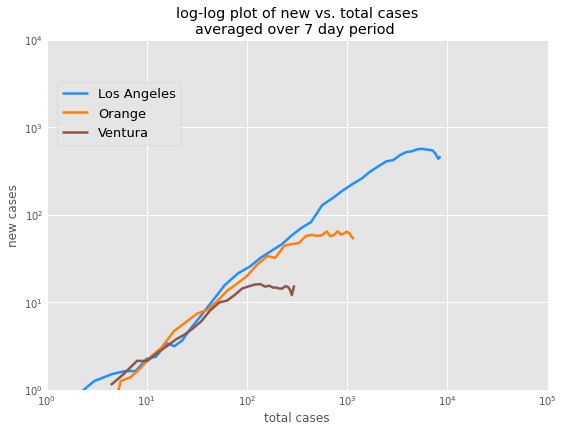

In [77]:
plt.style.use('ggplot')

# countylist = countylistga
# dfctemp = dfcatl
countylist = countylistca
dfctemp = dfcla


colorlist = ['dodgerblue', 'tab:orange', 'tab:brown', 'tab:green']
colordict = {countylist[i]:colorlist[i] for i in range(len(countylist))}
# modedict = {'step':[7,'-'], 'gauss':[1.5,'--'], 'median':[7,'-.']}
modedict = {'step':[7,'-']}
# modedict = {'gauss':[7/6,'-']}

fig, ax = plt.subplots(figsize=(8,6))
ls = dict(linewidth=2.50,linestyle='-',marker='o',ms=0,mfc='none',
              alpha=1, color='black')

for c in countylist[:]:
    
    dftemp = dfctemp[dfctemp['county']==c]

    ivec = np.arange(dftemp.shape[0])
    xvec = dftemp['cases'].to_numpy()
    yvec = dftemp['cases_new'].to_numpy()
    
    for m in modedict:
        width = modedict[m][0]
        xx, xvec1 = (cl.smooth(ivec, xvec, width, mode=m))
        xy, yvec1 = (cl.smooth(ivec, yvec, width, mode=m))
        xvec1log10 = np.log10(xvec1)
        yvec1log10 = np.log10(yvec1)
        
        ls['linestyle'] = modedict[m][1]
        ls['color'] = colordict[c]
#         ax.plot(xvec1log10, yvec1log10, **ls)
        ax.loglog(xvec1, yvec1, **ls)

plt.axis([1, 1e5, 1, 1e4])
# plt.axis([0,4,0,3])
# plt.grid()
plt.xlabel('total cases')
plt.ylabel('new cases')
plt.title('log-log plot of new vs. total cases\naveraged over {:d} day period '.format(*[7]))
plt.legend(countylist,
           fontsize=13,loc=(0.02,0.7))

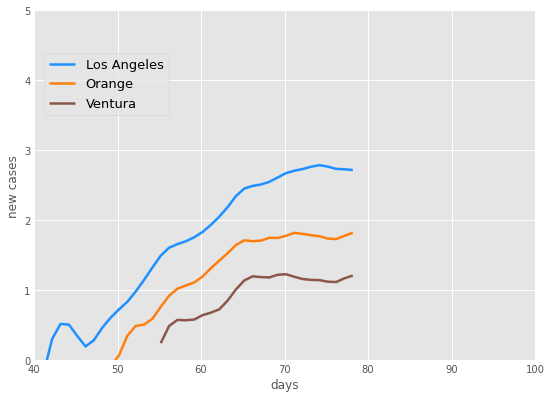

In [82]:
fig, ax = plt.subplots(figsize=(8,6))

# countylist = countylistga
# dfctemp = dfcatl
countylist = countylistca
dfctemp = dfcla

for c in countylist:
    dftemp = dfctemp[dfctemp['county']==c]
    
    ivec = np.arange(dftemp.shape[0])
    tvec = dftemp['days'].to_numpy()
    tvec = tvec
    
    yvec = (dftemp['cases_new'].to_numpy())
    wid = 7/6
    tvec, yvec = cl.smooth(tvec, yvec, wid, mode='gauss')
    yvec = np.log10(yvec)
    ls['color'] = colordict[c]
    ax.plot(tvec, yvec, **ls)
    

plt.axis([40,100,0,5])
plt.xlabel('days')
plt.ylabel('new cases')
plt.legend(countylist,
           fontsize=13,loc=(0.02,0.7))

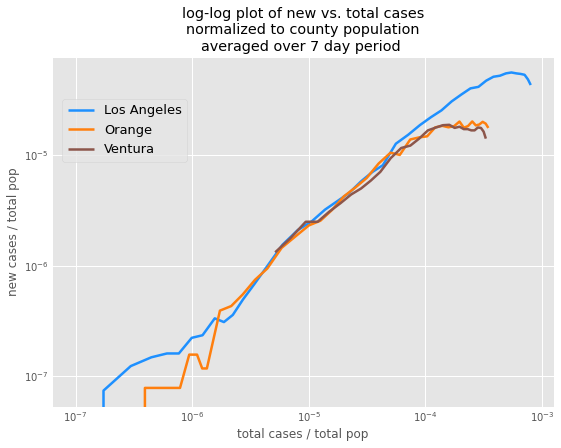

In [66]:
plt.style.use('ggplot')

# countylist = countylistga
# dfctemp = dfcatl
countylist = countylistca
dfctemp = dfcla


colorlist = ['dodgerblue', 'tab:orange', 'tab:brown', 'tab:green']
colordict = {countylist[i]:colorlist[i] for i in range(len(countylist))}
# modedict = {'step':[7,'-'], 'gauss':[1.5,'--'], 'median':[7,'-.']}
modedict = {'step':[7,'-']}
# modedict = {'gauss':[7/6,'-']}

fig, ax = plt.subplots(figsize=(8,6))
ls = dict(linewidth=2.50,linestyle='-',marker='o',ms=0,mfc='none',
              alpha=1, color='black')

for c in countylist[:]:
    
    dftemp = dfctemp[dfctemp['county']==c]

    ivec = np.arange(dftemp.shape[0])
    countypop = np.float(dfpop[dfpop['county'] == c]['pop'])
    xvec = dftemp['cases'].to_numpy() / countypop
    yvec = dftemp['cases_new'].to_numpy() / countypop
    
    for m in modedict:
        width = modedict[m][0]
        xx, xvec1 = (cl.smooth(ivec, xvec, width, mode=m))
        xy, yvec1 = (cl.smooth(ivec, yvec, width, mode=m))
        xvec1log10 = np.log10(xvec1)
        yvec1log10 = np.log10(yvec1)
        
        ls['linestyle'] = modedict[m][1]
        ls['color'] = colordict[c]
#         ax.plot(xvec1log10, yvec1log10, **ls)
        ax.loglog(xvec1, yvec1, **ls)

# plt.axis([1, 1e5, 1, 1e4])
# plt.axis([0,4,0,3])
# plt.grid()
plt.xlabel('total cases / total pop')
plt.ylabel('new cases / total pop')
plt.title('log-log plot of new vs. total cases\nnormalized to county population\naveraged over {:d} day period '.format(*[7]))
plt.legend(countylist,
           fontsize=13,loc=(0.02,0.7))

In [71]:
10**-3.5

0.00031622776601683794

In [68]:
xvec1

array([5.14120994e-06, 6.90391049e-06, 9.40106961e-06, 1.18982287e-05,
       1.49829547e-05, 1.86552475e-05, 2.30619989e-05, 2.80563171e-05,
       3.39319856e-05, 4.09827878e-05, 5.03838574e-05, 6.19883027e-05,
       7.41803149e-05, 8.82819193e-05, 1.05027575e-04, 1.22801472e-04,
       1.41456719e-04, 1.60258858e-04, 1.77885864e-04, 1.95953545e-04,
       2.13139875e-04, 2.30326205e-04, 2.47071861e-04, 2.63817516e-04,
       2.81591413e-04, 2.99218419e-04, 3.15523399e-04, 3.29625003e-04])

In [67]:
figpath = r'd:/Dropbox/py_projects/covid-19/reports/figures/'

fig.savefig(figpath+'log-log_new_v_total_per_population_LA_20200414.png',dpi=150,format='png',bbox_inches='tight')

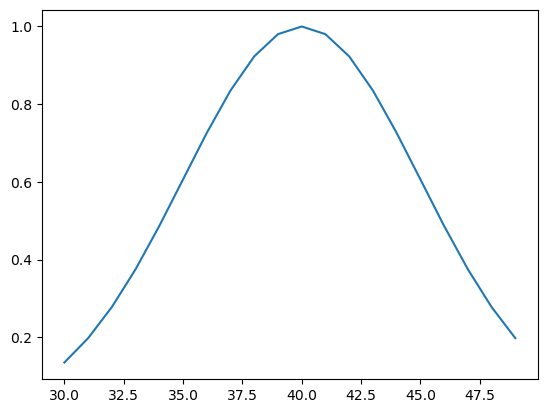

In [350]:
xvec = np.arange(30, 50, 1)
yvec = cl.gaussian(xvec, 40, 5)
plt.plot(xvec, yvec)

144.0


AttributeError: module 'customlib' has no attribute 'windowed'

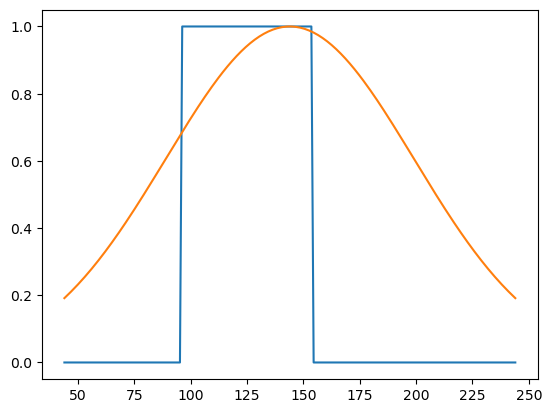

In [351]:
plt.style.use('default')
ivec = np.linspace(44, 244, 200)
yvec = cl.stepfunc(ivec, 125, 58)
plt.plot(ivec, yvec)
cen = ivec.min() + (ivec.max() - ivec.min())/2
print(cen)
wid = 55
yvec1 = cl.gaussian(ivec, cen, wid)
plt.plot(ivec, yvec1)
yvec2 = cl.windowed(ivec, yvec, wid, mode='gauss')
plt.plot(ivec, yvec2)

In [318]:
ivec.max() - 

244.0